In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn import linear_model
from sklearn import tree

from dataset_analysis import create_dataframe, create_dateTime, create_month
from dataset_analysis import specific_month_df, drop_month_year, alter_time, rearrange_frame
from dataset_analysis import check_A_B_blast_furnace_1, no_zero_value_in_target_1, dataframe_reset_index
from dataset_analysis import drop_nan_value, drop_unique_valued_columns, drop_string_column, dataframe_datetime

from dataset_analysis import feature_selection_with_selectKbest
from dataset_analysis import pearson_correlation
from dataset_analysis import make_dataframe_with_high_correlated_value
# from dataset_analysis import dataframe_date_time_type
from dataset_analysis import draw_graph
# from dataset_analysis import draw_feature_vs_target

In [3]:
from model_file import make_dataset, scikit_learn_model
from model_file import plot_graph, evaluation_metrices
# from model_file import NN_model
# from model_file import make_dataset_LSTM, split_sequence, LSTM_model

In [4]:
with open('variable_config.json', 'r') as f:
    config = json.load(f)

filepath = config['DEFAULT']['file_path']
filepath_ubuntu = config['DEFAULT']['file_path_ubuntu']
filepath_ubuntu_1 = config['DEFAULT']['file_path_ubuntu_1']
feb_march_file = config['DEFAULT']['feb_march_file']

filepath_server_feb_march = config['DEFAULT']['file_path_server_feb_march']
filepath_server_april_may = config['DEFAULT']['file_path_server_april_may']
filepath_server_june_july = config['DEFAULT']['file_path_server_june_july']


start_pos = config['DEFAULT']['start_point_dataframe']
end_pos = config['DEFAULT']['end_point_dataframe']
date_column = config['DEFAULT']['date_column']
target_column = config['DEFAULT']['target_column']
req_drop_value_target = config['DEFAULT']['req_drop_value_target']
furnace_signal_column_a = config['DEFAULT']['blast_furnace_signal_a']
furnace_signal_column_b = config['DEFAULT']['blast_furnace_signal_b']
value_A = config['DEFAULT']['req_value_of_blast_furnace_A']
value_B = config['DEFAULT']['req_value_of_blast_furnace_B']
max_best_number = config['DEFAULT']['max_best_number']
correlation_threshold_min_value = config['DEFAULT']['correlation_threshold_min_value']
correlation_threshold_max_value = config['DEFAULT']['correlation_threshold_max_value']
required_number_of_test_data = config['DEFAULT']['required_number_of_test_data']
subfolder_feature_vs_target = config['DEFAULT']['subfolder_feature_vs_target']
evaluation_metrics_file_name = config['DEFAULT']['evaluation_metrics_file']
number_of_step_lstm = config['DEFAULT']['n_steps_lstm']
epochs = config['DEFAULT']['epochs']
batch_size = config['DEFAULT']['batch_size']


print(filepath_server_feb_march)

/home/atif/feb_march_1.csv


In [5]:
%matplotlib inline
import re
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

In [6]:
initial_dataframe = create_dataframe(filepath_server_feb_march)

In [7]:
df_1 = create_dateTime(initial_dataframe,'row_ID','Unnamed: 0')

In [8]:
from dataset_analysis import create_month
date_df, month_array_df = create_month(df_1, 'month', target_column)

In [9]:
specific_month_df = specific_month_df(date_df,'month')

In [10]:
spec_month = drop_month_year(specific_month_df)

(45128, 4240)


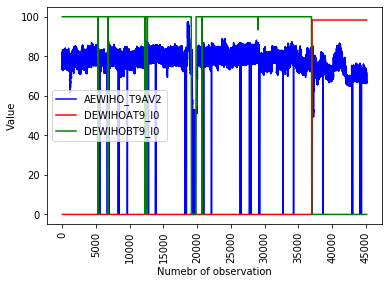

In [11]:
print(initial_dataframe.shape)
plt.plot(initial_dataframe[target_column], color = 'blue')
plt.plot(initial_dataframe[furnace_signal_column_a], color = 'red')
plt.plot(initial_dataframe[furnace_signal_column_b], color = 'green')
plt.legend([target_column, furnace_signal_column_a, furnace_signal_column_b], loc='best')
# plt.xlim(0,initial_dataframe.shape[0]+10)
plt.xticks(np.arange(0,initial_dataframe.shape[0],5000),rotation='vertical')
plt.xlabel('Numebr of observation')
plt.ylabel('Value')
# plt.savefig('blast_vs_target_pre.png',bbox_inches='tight')
plt.rcParams['figure.figsize'] = (12,5)

In [12]:
multivariate_data = alter_time(spec_month, start_pos,spec_month.shape[0])

In [13]:
index_array=[0,-1]
req_column_name = [date_column, target_column]
# req_column_name = [date_column, furnace_signal_column]
rearranged_dataframe = rearrange_frame(multivariate_data,req_column_name,index_array)

In [14]:
dataframe_no_zero_value_blast_furnace = check_A_B_blast_furnace_1(rearranged_dataframe, furnace_signal_column_a, value_A,
                                                               furnace_signal_column_b, value_B)

In [15]:
dataframe_no_zero_value_target_column = no_zero_value_in_target_1(dataframe_no_zero_value_blast_furnace,target_column, req_drop_value_target)

In [16]:
dataframe_no_zero_value_target_column_2 = dataframe_reset_index(dataframe_no_zero_value_target_column)
print(dataframe_no_zero_value_target_column_2.shape)

(43982, 4241)


In [17]:
multivariate_data_drop_nan = drop_nan_value(dataframe_no_zero_value_target_column_2)

In [18]:
dataframe_drop_column_with_same_value = drop_unique_valued_columns(multivariate_data_drop_nan)

In [19]:
dataframe_no_string = drop_string_column(dataframe_drop_column_with_same_value)

In [20]:
dataframe_no_string.shape

(43982, 2923)

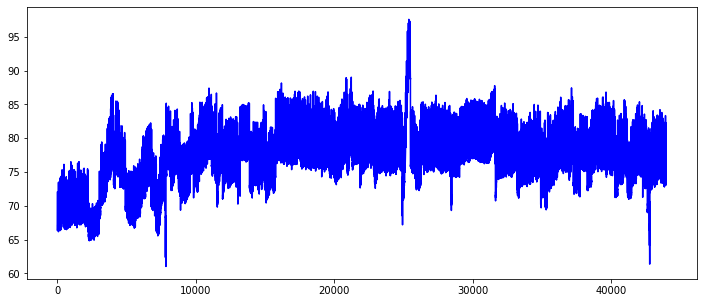

In [21]:
plt.plot(dataframe_no_string[target_column], color = 'blue')
# plt.plot(dataframe_no_zero_value_target_column[furnace_signal_column_a], color = 'red')
# plt.plot(dataframe_no_zero_value_target_column[furnace_signal_column_b], color = 'green')
# plt.legend([target_column, furnace_signal_column_a, furnace_signal_column_b], loc='upper left')
# plt.xlim(0,initial_dataframe.shape[0]+10)
# plt.xticks(np.arange(0,initial_dataframe.shape[0],))
plt.rcParams['figure.figsize'] = (12, 5)

In [22]:
dataframe_datetime = dataframe_datetime(dataframe_no_string)

In [23]:
def pearson_correlation(main_dataframe):
    main_correlation = main_dataframe.corr()
    return main_correlation

main_correlation = pearson_correlation(dataframe_datetime)

In [24]:
# make a dataframe with signal who is lies between a given range of correlation threshold value
main_frame = dataframe_datetime
correlated_frame = main_correlation

# main_frame = sklearn_feature_best_dataframe
# correlated_frame = sklearn_correlation

dataframe_high_correlation = make_dataframe_with_high_correlated_value(main_frame,correlated_frame,
                                                             correlation_threshold_min_value, correlation_threshold_max_value)

In [25]:
dataframe_high_correlation.shape

(43982, 4)

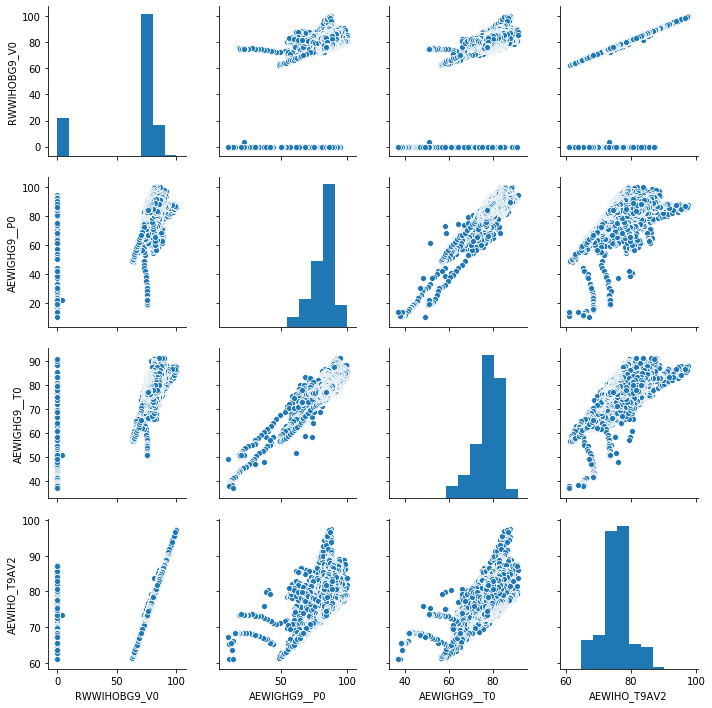

In [26]:
sns.pairplot(dataframe_high_correlation, height = 2.5)

In [27]:
df = dataframe_high_correlation

In [28]:
stat, p = stats.normaltest(df.iloc[:,-1])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=1599.592, p=0.000
Data does not look Gaussian (reject H0)


In [29]:

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    p_value = dfoutput['p-value']
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 
    
    if p_value <= 0.05:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
    

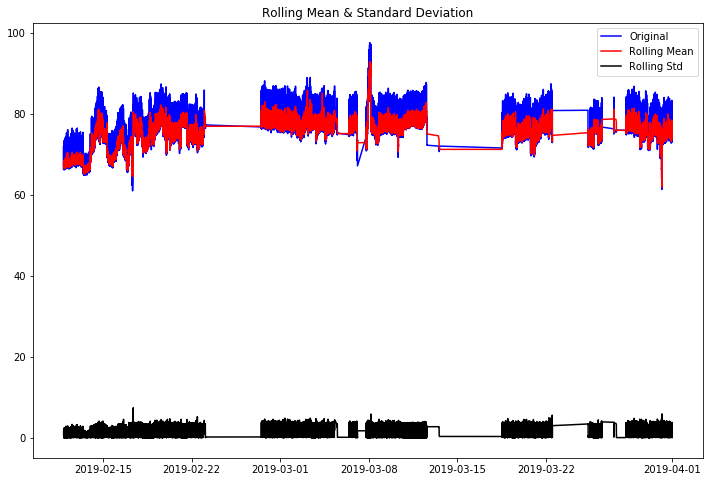

Results of Dickey-Fuller Test:
Test Statistic                -6.584293e+00
p-value                        7.380863e-09
#Lags Used                     4.800000e+01
Number of Observations Used    4.393300e+04
Critical Value (1%)           -3.430499e+00
Critical Value (5%)           -2.861606e+00
Critical Value (10%)          -2.566805e+00
dtype: float64
 => P-Value = 7.3808630862671725e-09. Rejecting Null Hypothesis.
 => Series is Stationary.


In [30]:
# df.iloc[:,-1]
test_stationarity(df.iloc[:,-1])

<Figure size 864x360 with 0 Axes>

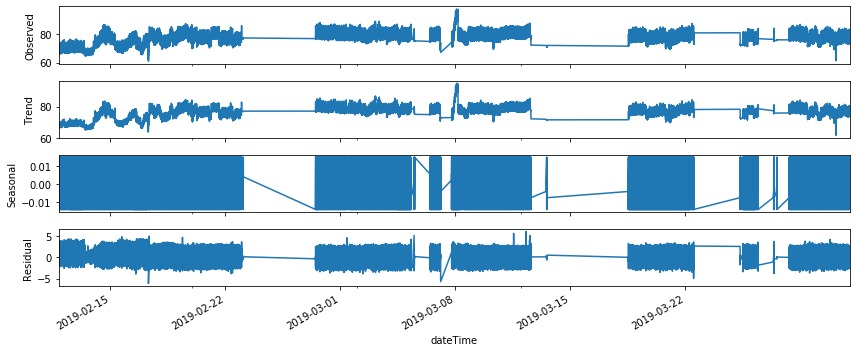

In [31]:
decomposition = seasonal_decompose(df.iloc[:,-1], freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12,5)

In [32]:
n_sample = df.shape[0]
print(n_sample)

43982


In [33]:
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

ts_train = df.iloc[:n_train][target_column]
ts_test = df.iloc[n_train:][target_column]
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.head(), "\n")
print("Testing Series:", "\n", ts_test.head())

(41783,)
(2199,)
Training Series: 
 dateTime
2019-02-11 20:57:00    66.387058
2019-02-11 20:58:00    66.765225
2019-02-11 20:59:00    66.767387
2019-02-11 21:00:00    66.859457
2019-02-11 21:01:00    66.869962
Name: AEWIHO_T9AV2, dtype: float64 

Testing Series: 
 dateTime
2019-03-30 11:21:00    83.634414
2019-03-30 11:22:00    83.233694
2019-03-30 11:23:00    80.248527
2019-03-30 11:24:00    77.111043
2019-03-30 11:25:00    75.994463
Name: AEWIHO_T9AV2, dtype: float64


In [34]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7ad164e978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7ad1586160>)

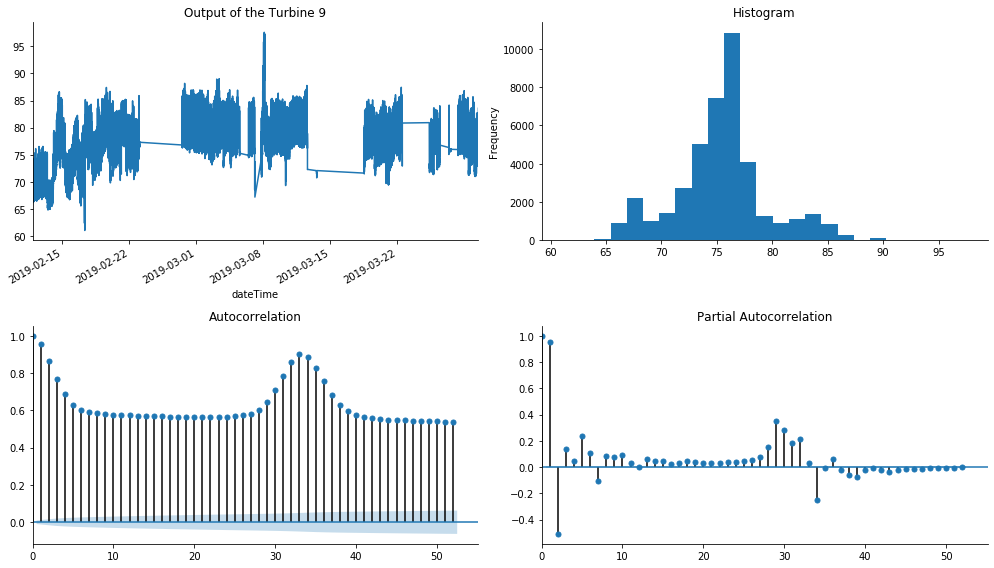

In [35]:
tsplot(ts_train, title='Output of the Turbine 9', lags=52)

In [ ]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 11
d_max = 0
q_max = 6

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = smt.SARIMAX(ts_train, order=(p, d, q),
                               enforce_stationarity=False,
                               enforce_invertibility=False,seasonal_order=(1,0,0,52)
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
        
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

In [ ]:
results_bic